---
## 🎯 Practice Exercises

### Exercise 1: Adaptive Reflection with Quality Metrics

**Task:** Improve Reflection with numerical quality scoring.

**Requirements:**
1. Critic scores draft on multiple criteria (1-5 each):
   - Clarity
   - Completeness
   - Accuracy
2. Use Pydantic model for structured scoring
3. Only refine if any score < 4
4. Track score improvements across iterations
5. Stop when all scores ≥ 4 or max iterations

**Example:**
```
Iteration 1: Clarity=3, Completeness=4, Accuracy=5 → Refine
Iteration 2: Clarity=5, Completeness=4, Accuracy=5 → Approved!
```

**Deliverables:**
- Reflection agent with quality metrics
- Test with task requiring refinement
- Visualize score improvements

In [1]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os

print("✅ All imports successful")

✅ All imports successful


In [2]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [3]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [5]:
# Exercise 1: Adaptive Reflection with Quality Metrics

from pydantic import BaseModel, Field
from typing import Optional

# Define Quality Score model
class QualityScore(BaseModel):
    """Structured quality scoring for output evaluation."""
    clarity: int = Field(ge=1, le=5, description="How clear and understandable is the content?")
    completeness: int = Field(ge=1, le=5, description="Does it cover all necessary points?")
    accuracy: int = Field(ge=1, le=5, description="Is the information accurate and factual?")
    
    def needs_refinement(self) -> bool:
        """Check if any score is below target."""
        return min(self.clarity, self.completeness, self.accuracy) < 4
    
    def all_excellent(self) -> bool:
        """Check if all scores are >= 4."""
        return min(self.clarity, self.completeness, self.accuracy) >= 4
    
    def __str__(self) -> str:
        return f"Clarity={self.clarity}, Completeness={self.completeness}, Accuracy={self.accuracy}"


# Initialize LLM for Exercise 1
exercise_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

# Define Reflection state with quality tracking
class ReflectionState(BaseModel):
    """State for adaptive reflection with quality metrics."""
    task: str
    draft: str
    score: Optional[QualityScore] = None
    score_history: list = Field(default_factory=list)  # Track all scores over iterations
    refinement_count: int = 0
    refined_output: str = ""
    final_output: str = ""
    approved: bool = False


# Convert to TypedDict for LangGraph
class ReflectionStateDict(TypedDict):
    task: str
    draft: str
    score: Optional[dict] = None
    score_history: list = []
    refinement_count: int = 0
    refined_output: str = ""
    final_output: str = ""
    approved: bool = False

print("✅ Quality metrics models defined")


✅ Quality metrics models defined


In [6]:
# Node 1: Generator - Creates initial draft
def reflection_generator(state: dict) -> dict:
    """Generate initial draft output."""
    print("\n" + "="*60)
    print("📝 GENERATOR NODE")
    print("="*60)
    
    prompt = f"""You are a content creator. Write a comprehensive, detailed response to the following task:

Task: {state['task']}

Create a well-structured, informative draft. Be thorough and cover all relevant aspects."""
    
    response = exercise_llm.invoke([HumanMessage(content=prompt)])
    draft = response.content
    
    print(f"\n📄 Draft generated ({len(draft)} characters)")
    print(f"Preview: {draft[:200]}...")
    
    return {"draft": draft}


# Node 2: Quality Critic - Scores output and provides feedback
def quality_critic(state: dict) -> dict:
    """Score and critique the draft output."""
    print("\n" + "="*60)
    print("🔍 QUALITY CRITIC NODE")
    print("="*60)
    
    prompt = f"""You are a critical evaluator. Score the following draft on three criteria (1-5 scale).

Task: {state['task']}

Draft Output:
{state['draft']}

Provide your scores in this EXACT format:
CLARITY: [1-5]
COMPLETENESS: [1-5]
ACCURACY: [1-5]
FEEDBACK: [Your feedback here explaining the scores and how to improve]

Be honest and thorough in your evaluation."""
    
    response = exercise_llm.invoke([HumanMessage(content=prompt)])
    response_text = response.content
    
    # Parse the scores from response
    try:
        lines = response_text.split('\n')
        clarity = int([l for l in lines if 'CLARITY:' in l][0].split(':')[1].strip())
        completeness = int([l for l in lines if 'COMPLETENESS:' in l][0].split(':')[1].strip())
        accuracy = int([l for l in lines if 'ACCURACY:' in l][0].split(':')[1].strip())
        feedback = '\n'.join([l for l in lines if 'FEEDBACK:' in l or (lines.index(l) > lines.index([l2 for l2 in lines if 'FEEDBACK:' in l2][0]) if [l2 for l2 in lines if 'FEEDBACK:' in l2] else False)])
    except:
        # Fallback scoring if parsing fails
        clarity, completeness, accuracy = 3, 3, 4
        feedback = response_text[:500]
    
    score = QualityScore(clarity=clarity, completeness=completeness, accuracy=accuracy)
    
    print(f"\n📊 Scores: {score}")
    print(f"\n💬 Feedback: {feedback[:300]}...")
    
    # Update score history
    new_history = state.get("score_history", []).copy()
    new_history.append({
        "iteration": state.get("refinement_count", 0) + 1,
        "scores": {"clarity": clarity, "completeness": completeness, "accuracy": accuracy},
        "text": str(score)
    })
    
    return {
        "score": {"clarity": clarity, "completeness": completeness, "accuracy": accuracy},
        "score_history": new_history
    }


# Node 3: Refiner - Improves draft based on scores
def quality_refiner(state: dict) -> dict:
    """Refine the draft based on quality scores."""
    print("\n" + "="*60)
    print("🔧 REFINER NODE - Iteration {state['refinement_count'] + 1}")
    print("="*60)
    
    # Identify weak areas
    score_dict = state.get("score", {})
    weak_areas = []
    if score_dict.get("clarity", 5) < 4:
        weak_areas.append("clarity and understanding")
    if score_dict.get("completeness", 5) < 4:
        weak_areas.append("completeness and coverage")
    if score_dict.get("accuracy", 5) < 4:
        weak_areas.append("accuracy and fact-checking")
    
    weak_areas_text = ", ".join(weak_areas) if weak_areas else "overall presentation"
    
    prompt = f"""You are a refinement expert. The draft below scored below 4 in: {weak_areas_text}

Original Task: {state['task']}

Current Draft:
{state['draft']}

Create an improved version that specifically addresses:
- {weak_areas_text}
- Maintain all accurate information
- Add more detail where needed
- Improve clarity and readability

Provide the REFINED version only, no explanations."""
    
    response = exercise_llm.invoke([HumanMessage(content=prompt)])
    refined = response.content
    
    new_count = state.get("refinement_count", 0) + 1
    print(f"\n✨ Refined version (Iteration {new_count}):")
    print(refined[:250] + "...")
    
    return {
        "refined_output": refined,
        "refinement_count": new_count,
        "draft": refined  # Update draft for next evaluation
    }


# Node 4: Finalizer - Completes process
def quality_finalizer(state: dict) -> dict:
    """Finalize the output."""
    print("\n" + "="*60)
    print("🎯 FINALIZER NODE")
    print("="*60)
    
    final = state.get("refined_output") or state["draft"]
    
    print("\n✅ Process complete!")
    print(f"Refinement iterations: {state.get('refinement_count', 0)}")
    
    # Display score progression
    if state.get("score_history"):
        print("\n📈 Score Progression:")
        for entry in state["score_history"]:
            print(f"  Iteration {entry['iteration']}: {entry['text']}")
    
    return {
        "final_output": final,
        "approved": True
    }

print("✅ All reflection nodes defined")


✅ All reflection nodes defined


In [7]:
# Conditional routing

def should_refine_quality(state: dict) -> Literal["refiner", "finalizer"]:
    """Decide whether to refine based on quality scores."""
    score_dict = state.get("score", {})
    
    # Check if any score is below 4
    min_score = min(
        score_dict.get("clarity", 4),
        score_dict.get("completeness", 4),
        score_dict.get("accuracy", 4)
    )
    
    refinement_count = state.get("refinement_count", 0)
    
    # Max 3 refinement iterations
    if refinement_count >= 3:
        print("\n⏹️  Max refinement iterations (3) reached")
        return "finalizer"
    
    if min_score < 4:
        print(f"\n🔄 Score {min_score} is below target 4, refining...")
        return "refiner"
    
    print("\n✓ All scores >= 4, quality approved!")
    return "finalizer"


# Build the reflection graph
reflection_builder = StateGraph(ReflectionStateDict)

# Add nodes
reflection_builder.add_node("generator", reflection_generator)
reflection_builder.add_node("critic", quality_critic)
reflection_builder.add_node("refiner", quality_refiner)
reflection_builder.add_node("finalizer", quality_finalizer)

# Add edges
reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add_conditional_edges("critic", should_refine_quality)
reflection_builder.add_edge("refiner", "critic")  # Re-evaluate after refinement
reflection_builder.add_edge("finalizer", END)

# Compile
reflection_graph = reflection_builder.compile()

print("✅ Quality reflection graph built!")
print("\nGraph flow: Generator → Critic → (Refiner → Critic loop) → Finalizer")


✅ Quality reflection graph built!

Graph flow: Generator → Critic → (Refiner → Critic loop) → Finalizer


In [8]:
# Test Exercise 1: Quality-driven reflection

test_task_ex1 = "Explain the impact of artificial intelligence on healthcare, focusing on diagnostics and treatment"

print("🚀 Running Adaptive Reflection Agent with Quality Metrics")
print(f"📋 Task: {test_task_ex1}\n")

# Initial state
initial_reflection_state = {
    "task": test_task_ex1,
    "draft": "",
    "score": None,
    "score_history": [],
    "refinement_count": 0,
    "refined_output": "",
    "final_output": "",
    "approved": False
}

# Run the reflection graph
reflection_final_state = reflection_graph.invoke(initial_reflection_state)

print("\n\n" + "="*80)
print("📊 QUALITY REFLECTION RESULTS")
print("="*80)

print("\n📋 TASK:")
print(reflection_final_state["task"])

print("\n📝 INITIAL DRAFT:")
print(reflection_final_state["draft"][:400] + "..." if len(reflection_final_state["draft"]) > 400 else reflection_final_state["draft"])

print("\n\n📈 QUALITY SCORE PROGRESSION:")
print("-" * 60)
if reflection_final_state.get("score_history"):
    for entry in reflection_final_state["score_history"]:
        print(f"Iteration {entry['iteration']}: {entry['text']}")
else:
    if reflection_final_state.get("score"):
        clarity = reflection_final_state["score"].get("clarity", 0)
        completeness = reflection_final_state["score"].get("completeness", 0)
        accuracy = reflection_final_state["score"].get("accuracy", 0)
        print(f"Final Scores: Clarity={clarity}, Completeness={completeness}, Accuracy={accuracy}")

print("\n\n🎯 FINAL OUTPUT:")
print("-" * 60)
final_output = reflection_final_state.get("final_output") or reflection_final_state.get("draft")
print(final_output)

print("\n\n" + "="*80)
print(f"✅ Reflection Complete!")
print(f"   - Refinement iterations: {reflection_final_state.get('refinement_count', 0)}")
print(f"   - Final approval status: {reflection_final_state.get('approved', False)}")
print("="*80)


🚀 Running Adaptive Reflection Agent with Quality Metrics
📋 Task: Explain the impact of artificial intelligence on healthcare, focusing on diagnostics and treatment


📝 GENERATOR NODE

📄 Draft generated (6535 characters)
Preview: **The Impact of Artificial Intelligence on Healthcare: A Focus on Diagnostics and Treatment**

**Introduction**

The integration of artificial intelligence (AI) into healthcare is transforming the lan...

🔍 QUALITY CRITIC NODE

📊 Scores: Clarity=5, Completeness=4, Accuracy=5

💬 Feedback: FEEDBACK: The draft is clear and well-structured, making it easy for readers to follow the discussion on the impact of AI in healthcare, particularly in diagnostics and treatment. Each section is logically organized, and the use of subheadings helps to guide the reader through the content. The expla...

✓ All scores >= 4, quality approved!

🎯 FINALIZER NODE

✅ Process complete!
Refinement iterations: 0

📈 Score Progression:
  Iteration 1: Clarity=5, Completeness=4, Accuracy=5



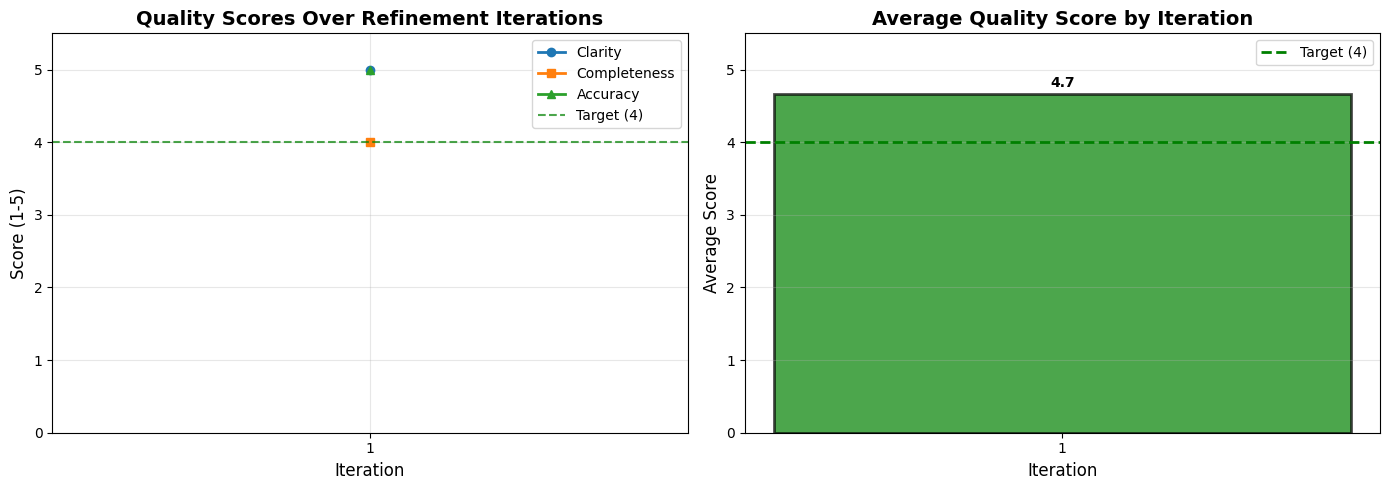


📊 QUALITY METRICS SUMMARY
Initial Average Score: 4.67
Final Average Score: 4.67
Total Improvement: 0.00 points
Refinement Iterations: 0
Goal Achieved: ✅ Yes

✅ Exercise 1 Complete!


In [9]:
# Visualize score improvements

import matplotlib.pyplot as plt
import numpy as np

def visualize_quality_progression(final_state):
    """Create visualization of quality score progression."""
    
    score_history = final_state.get("score_history", [])
    
    if not score_history:
        print("No score history to visualize")
        return
    
    # Extract data
    iterations = [entry["iteration"] for entry in score_history]
    clarity_scores = [entry["scores"]["clarity"] for entry in score_history]
    completeness_scores = [entry["scores"]["completeness"] for entry in score_history]
    accuracy_scores = [entry["scores"]["accuracy"] for entry in score_history]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Line chart of scores over iterations
    ax1.plot(iterations, clarity_scores, marker='o', label='Clarity', linewidth=2)
    ax1.plot(iterations, completeness_scores, marker='s', label='Completeness', linewidth=2)
    ax1.plot(iterations, accuracy_scores, marker='^', label='Accuracy', linewidth=2)
    ax1.axhline(y=4, color='green', linestyle='--', label='Target (4)', alpha=0.7)
    
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Score (1-5)', fontsize=12)
    ax1.set_title('Quality Scores Over Refinement Iterations', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 5.5)
    ax1.set_xticks(iterations)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Average score progression
    avg_scores = [
        np.mean([c, comp, acc])
        for c, comp, acc in zip(clarity_scores, completeness_scores, accuracy_scores)
    ]
    
    colors = ['red' if score < 4 else 'green' for score in avg_scores]
    bars = ax2.bar(iterations, avg_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax2.axhline(y=4, color='green', linestyle='--', linewidth=2, label='Target (4)')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Average Score', fontsize=12)
    ax2.set_title('Average Quality Score by Iteration', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 5.5)
    ax2.set_xticks(iterations)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (iteration, score) in enumerate(zip(iterations, avg_scores)):
        ax2.text(iteration, score + 0.1, f'{score:.1f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 QUALITY METRICS SUMMARY")
    print("="*50)
    print(f"Initial Average Score: {avg_scores[0]:.2f}")
    print(f"Final Average Score: {avg_scores[-1]:.2f}")
    print(f"Total Improvement: {avg_scores[-1] - avg_scores[0]:.2f} points")
    print(f"Refinement Iterations: {len(iterations) - 1}")
    print(f"Goal Achieved: {'✅ Yes' if avg_scores[-1] >= 4 else '❌ No'}")
    print("="*50)

# Run visualization
visualize_quality_progression(reflection_final_state)

print("\n✅ Exercise 1 Complete!")
